In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv("./csvs/acquisition.csv", dtype=object, delimiter=",")
print(data.shape)
data.head(5)

(7452, 22)


,Transaction Name,Acquiree Name,Acquirer Name,Announced Date,Price,Acquisition Type,Acquisition Terms,Acquiree Description,Acquiree Last Funding Type,Acquiree Industries,...,Acquiree's Total Funding Amount,Acquiree Funding Status,Acquiree's Number of Funding Rounds,Acquirer's Description,Acquirer Industries,Acquirer Headquarters Location,Acquirer's Estimated Revenue Range,Acquirer's Total Funding Amount,Acquirer Funding Status,Acquirer's Number of Funding Rounds
0,"Signio, Inc. acquired by VeriSign","Signio, Inc.",VeriSign,"Dec 20, 1999","$733,000,000",Acquisition,Cash & Stock,"Signio, Inc. provides payment services connect...",—,Transaction Processing,...,—,M&A,—,Verisign operates the infrastructure for the ....,"Cyber Security, Information Technology, Infras...","Bluemont, Virginia, United States",—,"$39,311,110",IPO,3
1,Creon Lab Control acquired by Waters Corporation,Creon Lab Control,Waters Corporation,"Jul 30, 2003","$16,000,000",Acquisition,—,CLC provides Laboratory Information Management...,—,"Chemical, Pharmaceutical, Software",...,—,M&A,—,Waters Division creates business advantages fo...,Search Engine,"Milford, Massachusetts, United States",—,—,IPO,—
2,Schneller acquired by TransDigm,Schneller,TransDigm,"Aug 4, 2011","$288,500,000",Acquisition,Cash,Schneller designs and manufactures proprietary...,—,Aerospace,...,—,M&A,—,"TransDigm is a global designer, producer, and ...","Aerospace, Manufacturing","Cleveland, Ohio, United States",—,"$133,789,999",IPO,1
3,Benzlers acquired by Textron,Benzlers,Textron,"Oct 27, 1999",—,Acquisition,—,Benzlers is a manufacturer of mechanical power...,—,Machinery Manufacturing,...,—,M&A,—,Textron Inc. is a multi-industry company that ...,"Aerospace, Finance, Industrial","Providence, Rhode Island, United States",—,—,IPO,—
4,Travelex Global Business Payments acquired by ...,Travelex Global Business Payments,Western Union,"Jul 5, 2011","£606,000,000",Acquisition,Cash,Travelex Global Business Payments provides bus...,—,"B2B, Financial Services",...,—,M&A,—,Western Union provides consumers and businesse...,"Internet, Mobile Payments, Payments","Englewood, Colorado, United States",—,—,IPO,—


## Preprocessing

### Features: 
1. acquirer id (0 - 437)
2. acquirer location (1 if in the United States, otherwise 0)
3. Acquirer Funding Status {0: '—', 1: 'M&A', 2: 'IPO'}
4. acquirer top 5 industries (0 - 576, -1 for padding) 
5. acquiree location (1 if in the United States, otherwise 0)
6. acquiree top 5 industries (0 - 576, -1 for padding)


In [2]:
# 1. acquirer id
acquirer_names = set(data.loc[:, 'Acquirer Name'])
print(len(acquirer_names))
id2acquirer = {i : name for i, name in enumerate(acquirer_names)}
acquirer2id = {value : key for key, value in id2acquirer.items()}

def encode_acquirer_name(name):
    return [acquirer2id[name]]

# 2. location
def encode_location(location):
    if 'United States' in location:
        return [1]
    return [0]

# 3. industries
industries = set()
for i in data.loc[:, 'Acquirer Industries']:
    for j in i.split(','):
        industries.add(j.strip())
for i in data.loc[:, 'Acquiree Industries']:
    for j in i.split(','):
        industries.add(j.strip())
id2industry = {i : ind for i, ind in enumerate(industries)}
industry2id = {value : key for key, value in id2industry.items()}
print(len(industries))

def encode_industries(industries):
    res = [industry2id[i.strip()] for i in industries.split(',')]
    if (len(res) >= 5):
        return res[:5]
    for i in range(5 - len(res)):
        res += [-1]
    return res

# 4. Acquirer Funding Status
acquirer_status = set(data.loc[:, 'Acquirer Funding Status'])
print(len(acquirer_status))
id2status = {i : name for i, name in enumerate(acquirer_status)}
status2id = {value : key for key, value in id2status.items()}

def encode_status(status):
    return [status2id[status]]

# encode
def encode_row(row):
    res = []
    res += encode_acquirer_name(row['Acquirer Name'])
    res += encode_location(row['Acquirer Headquarters Location'])
    res += encode_status(row['Acquirer Funding Status'])
    res += encode_industries(row['Acquirer Industries'])
    
    res += encode_location(row['Acquiree Headquarters Location'])
    res += encode_industries(row['Acquiree Industries'])
    return res

print('raw data')
print(data.iloc[1])
print('encoded data')
print(encode_row(data.iloc[1]))

438
577
3
raw data
Transaction Name                        Creon Lab Control acquired by Waters Corporation
Acquiree Name                                                          Creon Lab Control
Acquirer Name                                                         Waters Corporation
Announced Date                                                              Jul 30, 2003
Price                                                                        $16,000,000
Acquisition Type                                                             Acquisition
Acquisition Terms                                                                      —
Acquiree Description                   CLC provides Laboratory Information Management...
Acquiree Last Funding Type                                                             —
Acquiree Industries                                   Chemical, Pharmaceutical, Software
Acquiree Headquarters Location                     Frechen, Nordrhein-Westfalen, Germany
Ac

### Negative Sampling

In [3]:
from random import randint

def negative_sampling(data, num):
    return [neg_sampling(data) for i in range(num)]

def neg_sampling(data):
    i = randint(0, data.shape[0] - 1)
    j = randint(0, data.shape[0] - 1)
    row_i = encode_row(data.iloc[i])
    row_j = encode_row(data.iloc[j])
    while (row_i[0] == row_j[0]):
        i = randint(0, data.shape[0] - 1)
        row_i = encode_row(data.iloc[i])
    return row_i[:8] + row_j[8:] + [0]

negative_sampling(data, 10)

[[349, 1, 0, 180, 54, 145, -1, -1, 0, 27, -1, -1, -1, -1, 0],
 [282, 1, 0, 82, 315, 242, 112, 48, 1, 243, 560, 496, -1, -1, 0],
 [311, 1, 0, 54, 138, 57, -1, -1, 1, 275, 243, 36, 474, 496, 0],
 [116, 1, 0, 205, 263, 496, -1, -1, 1, 459, 349, 148, 496, -1, 0],
 [56, 1, 0, 275, 1, -1, -1, -1, 1, 485, 166, 496, -1, -1, 0],
 [72, 1, 0, 275, 209, 372, 451, 354, 1, 209, 451, 560, 496, -1, 0],
 [116, 1, 0, 205, 263, 496, -1, -1, 1, 496, -1, -1, -1, -1, 0],
 [217, 1, 0, 43, 321, 263, 159, 383, 0, 560, 166, -1, -1, -1, 0],
 [217, 1, 0, 43, 321, 263, 159, 383, 1, 454, 116, 3, -1, -1, 0],
 [12, 1, 0, 205, 451, 560, 496, -1, 1, 380, 137, -1, -1, -1, 0]]

### Train-test split

In [85]:
# negative sampling
positive = np.array([encode_row(data.iloc[i]) + ['1'] for i in range(data.shape[0])])
negative = np.array(2*negative_sampling(data, data.shape[0]))
print(positive.shape)
print(negative.shape)

(7452, 15)
(14904, 15)


In [86]:
augmented_data = np.concatenate((positive, negative), axis=0)
np.random.shuffle(augmented_data)
print(augmented_data.shape)
print(augmented_data)

(22356, 15)
[['6' '1' '0' ... '-1' '-1' '0']
 ['65' '1' '0' ... '514' '-1' '0']
 ['290' '1' '0' ... '-1' '-1' '0']
 ...
 ['158' '1' '0' ... '-1' '-1' '0']
 ['64' '1' '0' ... '-1' '-1' '0']
 ['16' '1' '0' ... '-1' '-1' '0']]


In [87]:
from sklearn.model_selection import train_test_split
# split
X = augmented_data[:, :-1]
y = augmented_data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(17884, 14) (4472, 14)
(17884,) (4472,)


## Decision Tree

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None)
dtree.fit(X_train,y_train)

# prediction
prediction = dtree.predict(X_test)
# evalutation
def evaluate(prediction, labels):
    TP = TN = FP = FN = 0
    for i, label in enumerate(labels):
        if (prediction[i] == '1' and label == '1'):
            TP += 1
        elif (prediction[i] == '0' and label == '0'):
            TN += 1
        elif (prediction[i] == '0' and label == '1'):
            FN += 1
        elif (prediction[i] == '1' and label == '0'):
            FP += 1
    accuracy = (TP + TN) / (TP + TN + FN + FP)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = 2 * precision * recall / (recall + precision)
    return {'accuracy': accuracy, 'recall': recall, 'precision': precision, 'F1': F1}

print('training accuracy: ', dtree.score(X_train, y_train))
evaluate(prediction, y_test)

training accuracy:  0.9859091925743682


{'F1': 0.6977272727272728,
 'accuracy': 0.8215563506261181,
 'precision': 0.8157661647475642,
 'recall': 0.6095301125082727}

## Visualize DTree

14


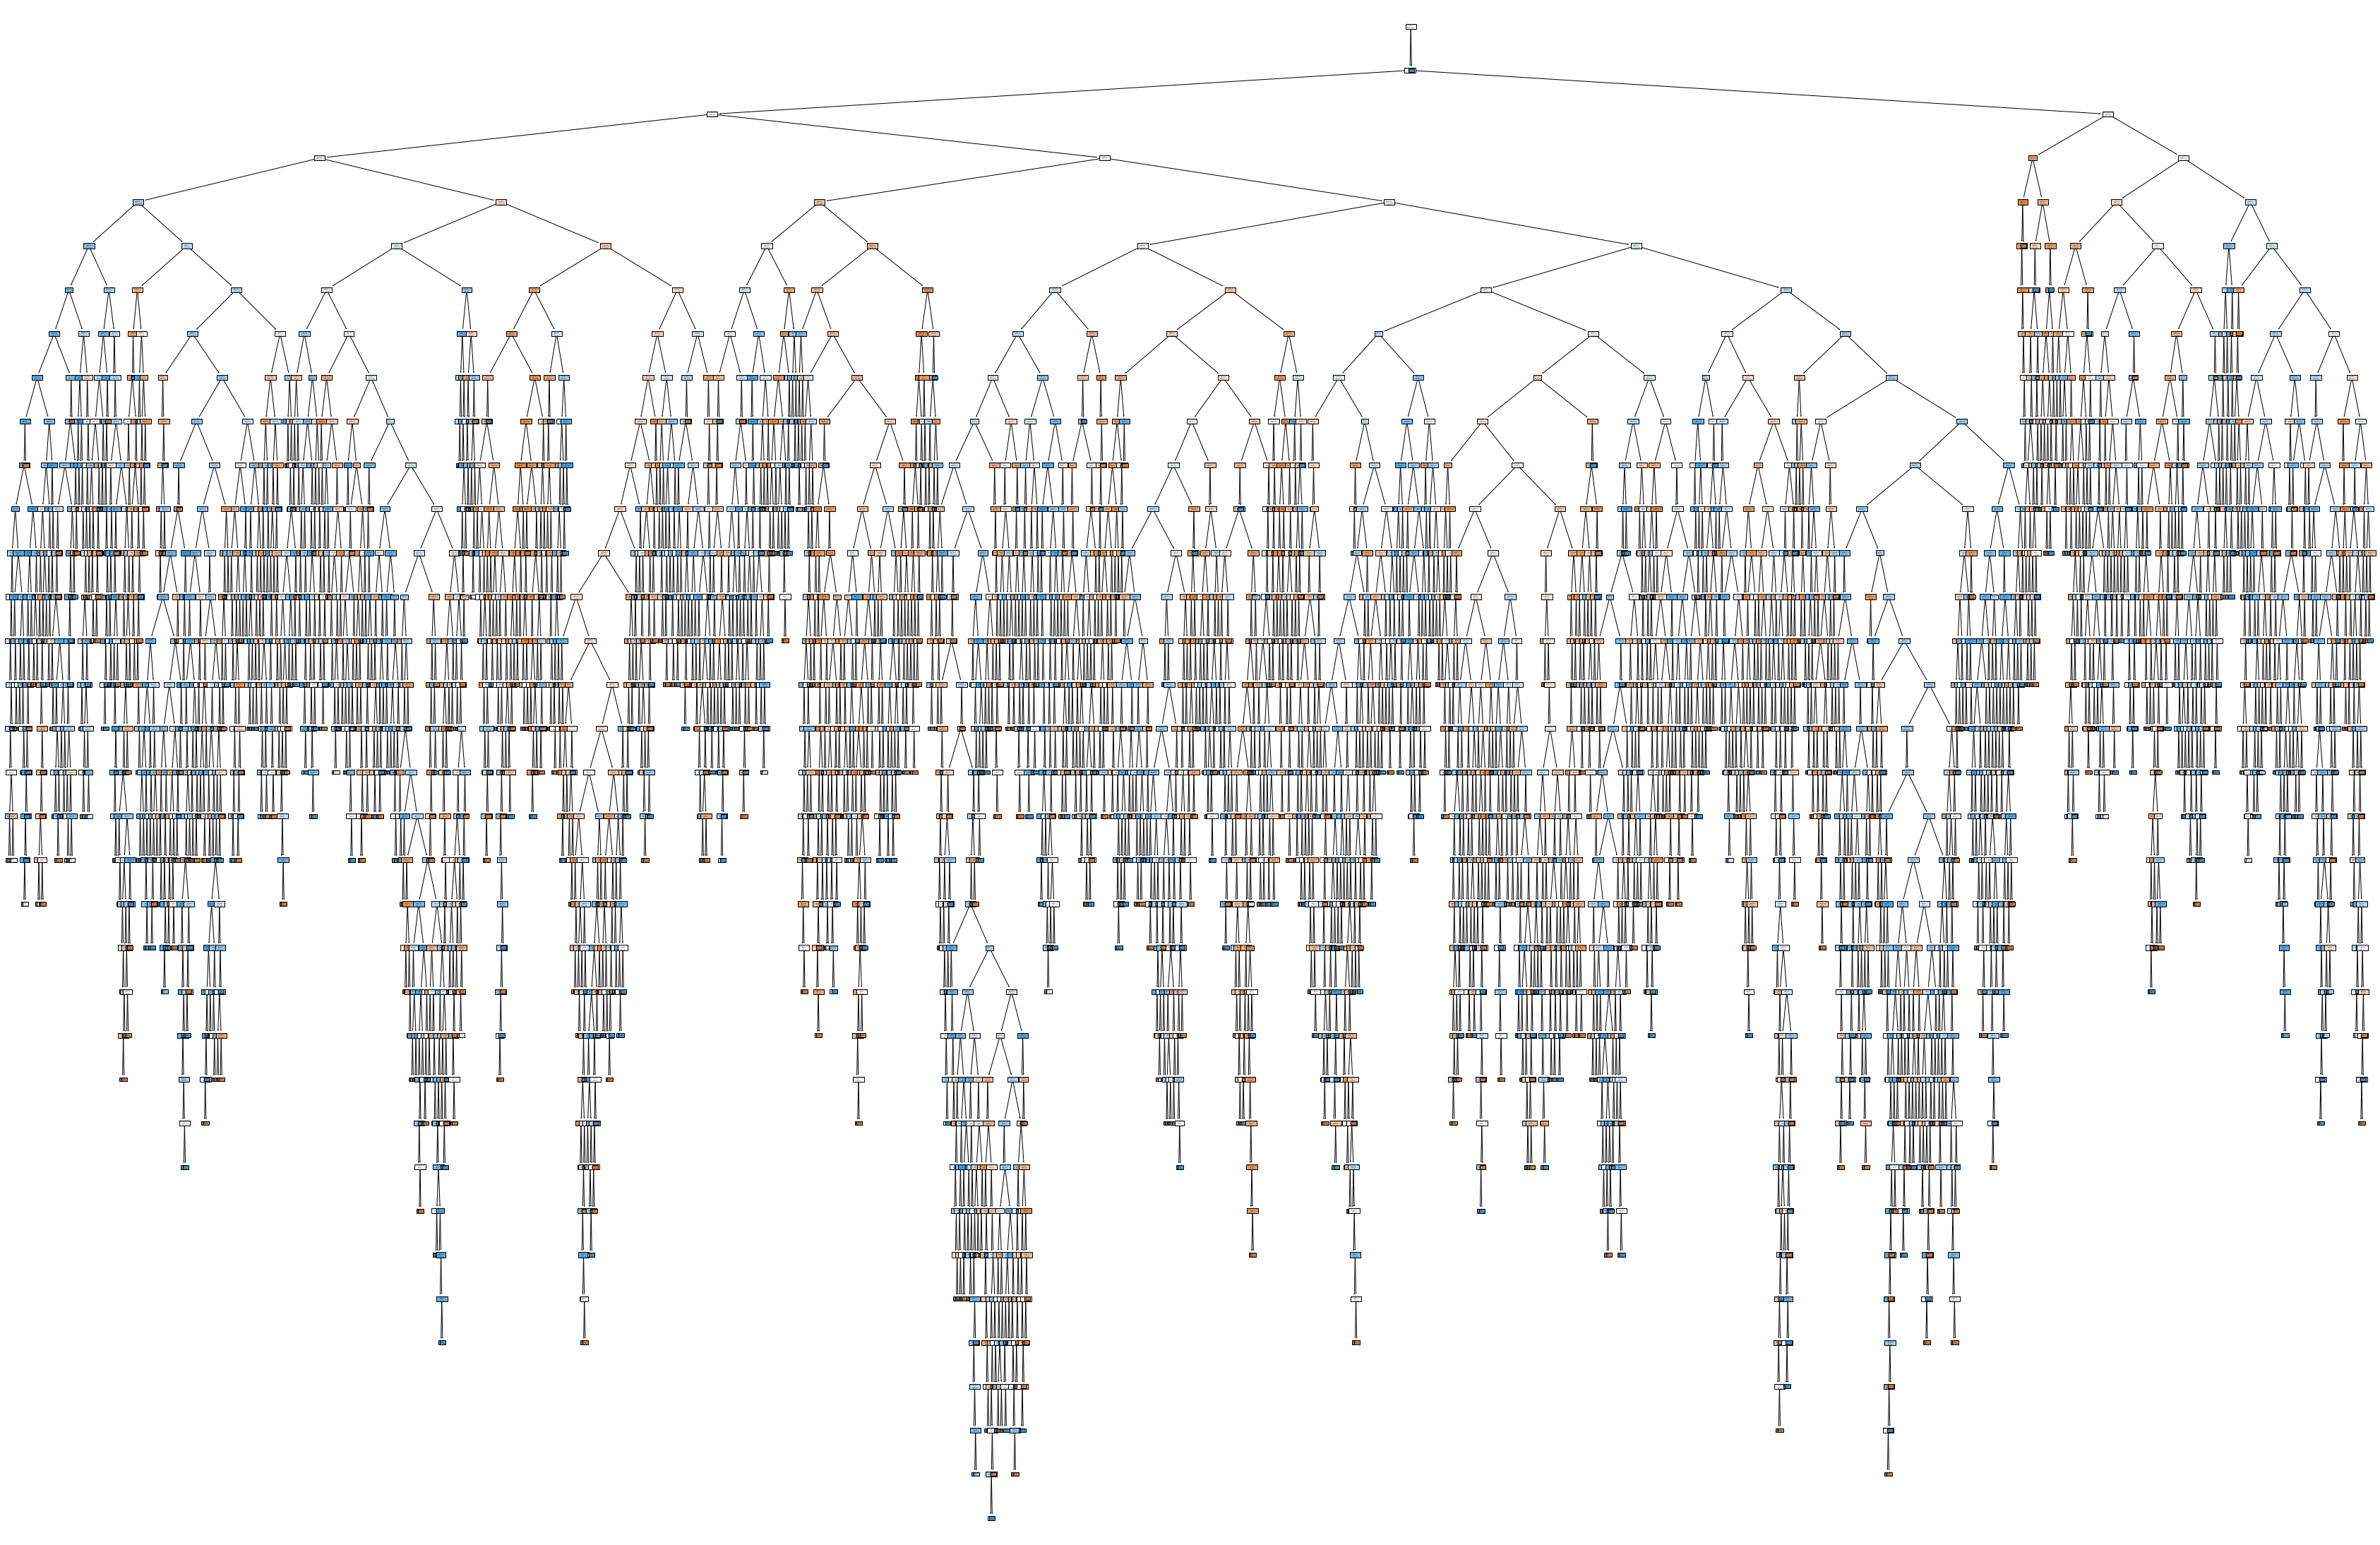

In [48]:
# visualization
feature_names = np.array([
    'acquirer id',
    'acquirer location',
    'acquirer funding status',
    'acquirer industry 1',
    'acquirer industry 2',
    'acquirer industry 3',
    'acquirer industry 4',
    'acquirer industry 5',
    'acquiree location',
    'acquiree industry 1',
    'acquiree industry 2',
    'acquiree industry 3',
    'acquiree industry 4',
    'acquiree industry 5'
])
print(len(feature_names))
class_names = ['NO', 'YES']
plt.figure(figsize=(60, 40))
plot_tree(dtree, feature_names=feature_names, class_names=class_names, filled=True);

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, \
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, \
                            max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, \
                            min_impurity_split=None, bootstrap=True, oob_score=True, n_jobs=None, \
                            random_state=None, verbose=0, warm_start=False, class_weight=None)
rf.fit(X_train, y_train)
print('training accuracy: ', rf.score(X_train, y_train))
print('out-of-bag score: ', rf.oob_score_)
# prediction
prediction = rf.predict(X_test)
evaluate(prediction, y_test)

training accuracy:  0.986412815566552
out-of-bag score:  0.6552042271240459


{'F1': 0.6690741956664478,
 'accuracy': 0.6618584367661858,
 'precision': 0.658694246929541,
 'recall': 0.6797865243495663}

## Default Feature Importance (sklearn)

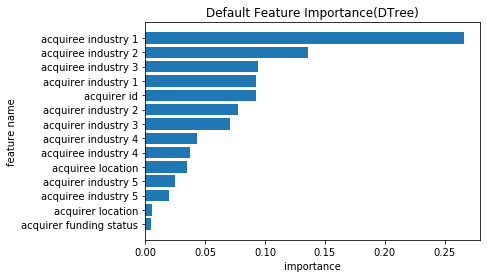

In [83]:
dt_fi = dtree.feature_importances_
rf_fi = rf.feature_importances_
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, np.sort(dt_fi))
plt.yticks(y_pos, feature_names[np.argsort(dt_fi)])
plt.title('Default Feature Importance(DTree)')
plt.ylabel('feature name')
plt.xlabel('importance')
plt.show()

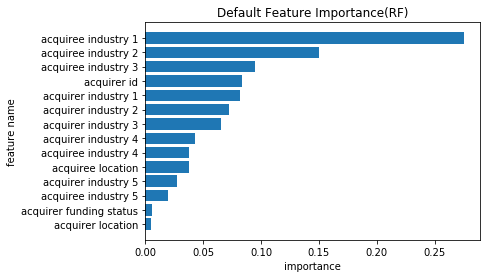

In [84]:
plt.barh(y_pos, np.sort(rf_fi))
plt.yticks(y_pos, feature_names[np.argsort(rf_fi)])
plt.title('Default Feature Importance(RF)')
plt.ylabel('feature name')
plt.xlabel('importance')
plt.show()

## Drop Column feature importance

In [77]:
from sklearn.base import clone 

def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
            'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    if isinstance(model, DecisionTreeClassifier):
        benchmark_score = model_clone.score(X_train, y_train)
    else:
        benchmark_score = model_clone.oob_score_
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        if isinstance(model, DecisionTreeClassifier):
            drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        else:
            drop_col_score = model_clone.oob_score_
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df


In [78]:
X_train_df = pd.DataFrame(data=X_train, columns=feature_names)
dt_fi = drop_col_feat_imp(dtree, X_train_df, y_train, random_state = 42)
rf_fi = drop_col_feat_imp(rf, X_train_df, y_train, random_state = 42)

In [79]:
dt_fi

,feature,feature_importance
0,acquiree industry 1,0.090330
1,acquiree industry 2,0.012665
2,acquiree location,0.005787
3,acquiree industry 3,0.002936
4,acquirer id,0.000335
5,acquirer location,0.000000
6,acquirer funding status,0.000000
7,acquirer industry 1,0.000000
8,acquirer industry 2,0.000000
9,acquirer industry 3,0.000000


In [80]:
rf_fi

,feature,feature_importance
0,acquiree industry 1,0.041097
1,acquirer industry 1,0.005368
2,acquirer industry 2,0.001006
3,acquirer industry 3,-0.000503
4,acquiree industry 2,-0.002768
5,acquirer funding status,-0.003019
6,acquiree industry 3,-0.003606
7,acquirer location,-0.003858
8,acquirer industry 4,-0.004697
9,acquirer industry 5,-0.004697


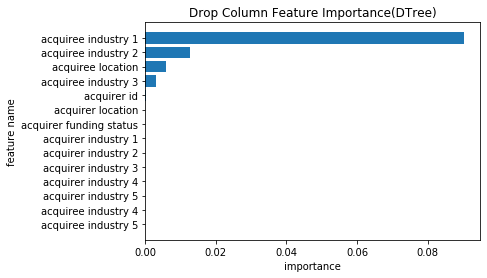

In [81]:
y_pos = np.arange(14)[::-1]
plt.barh(y_pos, dt_fi['feature_importance'])
plt.yticks(y_pos, dt_fi['feature'])
plt.title('Drop Column Feature Importance(DTree)')
plt.ylabel('feature name')
plt.xlabel('importance')
plt.show()

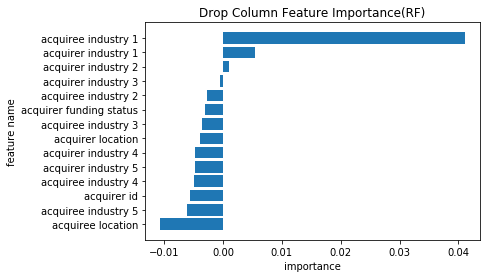

In [82]:
y_pos = np.arange(14)[::-1]
plt.barh(y_pos, rf_fi['feature_importance'])
plt.yticks(y_pos, rf_fi['feature'])
plt.title('Drop Column Feature Importance(RF)')
plt.ylabel('feature name')
plt.xlabel('importance')
plt.show()